# Graph classification with Graph Convolutional Networks

In this notebook, we will use the `torch_geometric` library to classify graphs. We will use the `MUTAG` dataset (from the [TUDataset repository](https://chrsmrrs.github.io/datasets/)). Here is a description of the dataset as reported [here](https://paperswithcode.com/dataset/mutag):

> MUTAG is a collection of nitroaromatic compounds and the goal is to predict their mutagenicity on Salmonella typhimurium. Input graphs are used to represent chemical compounds, where vertices stand for atoms and are labeled by one of 7 possible atom types (represented by one-hot encoding), while edges between vertices represent bonds between the corresponding atoms.

In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00


In [3]:
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from rich.progress import track
import matplotlib.pyplot as plt
import networkx as nx


# Data loading

In [4]:

dataset_path = "data/TUDataset"
dataset = TUDataset(root=dataset_path, name='MUTAG')

dataset.download()

train = dataset[:150]
test = dataset[150:]

Processing...
Done!


In [5]:
train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=False)

In `torch_geometric` the graph data is represented as a `Data` object, which contains (among others) the following attributes:
- `x`: node features
- `edge_index`: edge indices
- `edge_attr`: edge features
- `y`: graph label

In [6]:
train[0]

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])

In [9]:
edges = torch.tensor([
    [1,3],
    [2, 4],
    [1, 5]
]).T

edges.shape

torch.Size([2, 3])

The first graph in the dataset has 17 nodes and 38 edges. The nodes have 7 features (one-hot encoding of the atom type) and the edges have 4 features (one-hot encoding of 4 edge types). The graph is labeled as `1`.

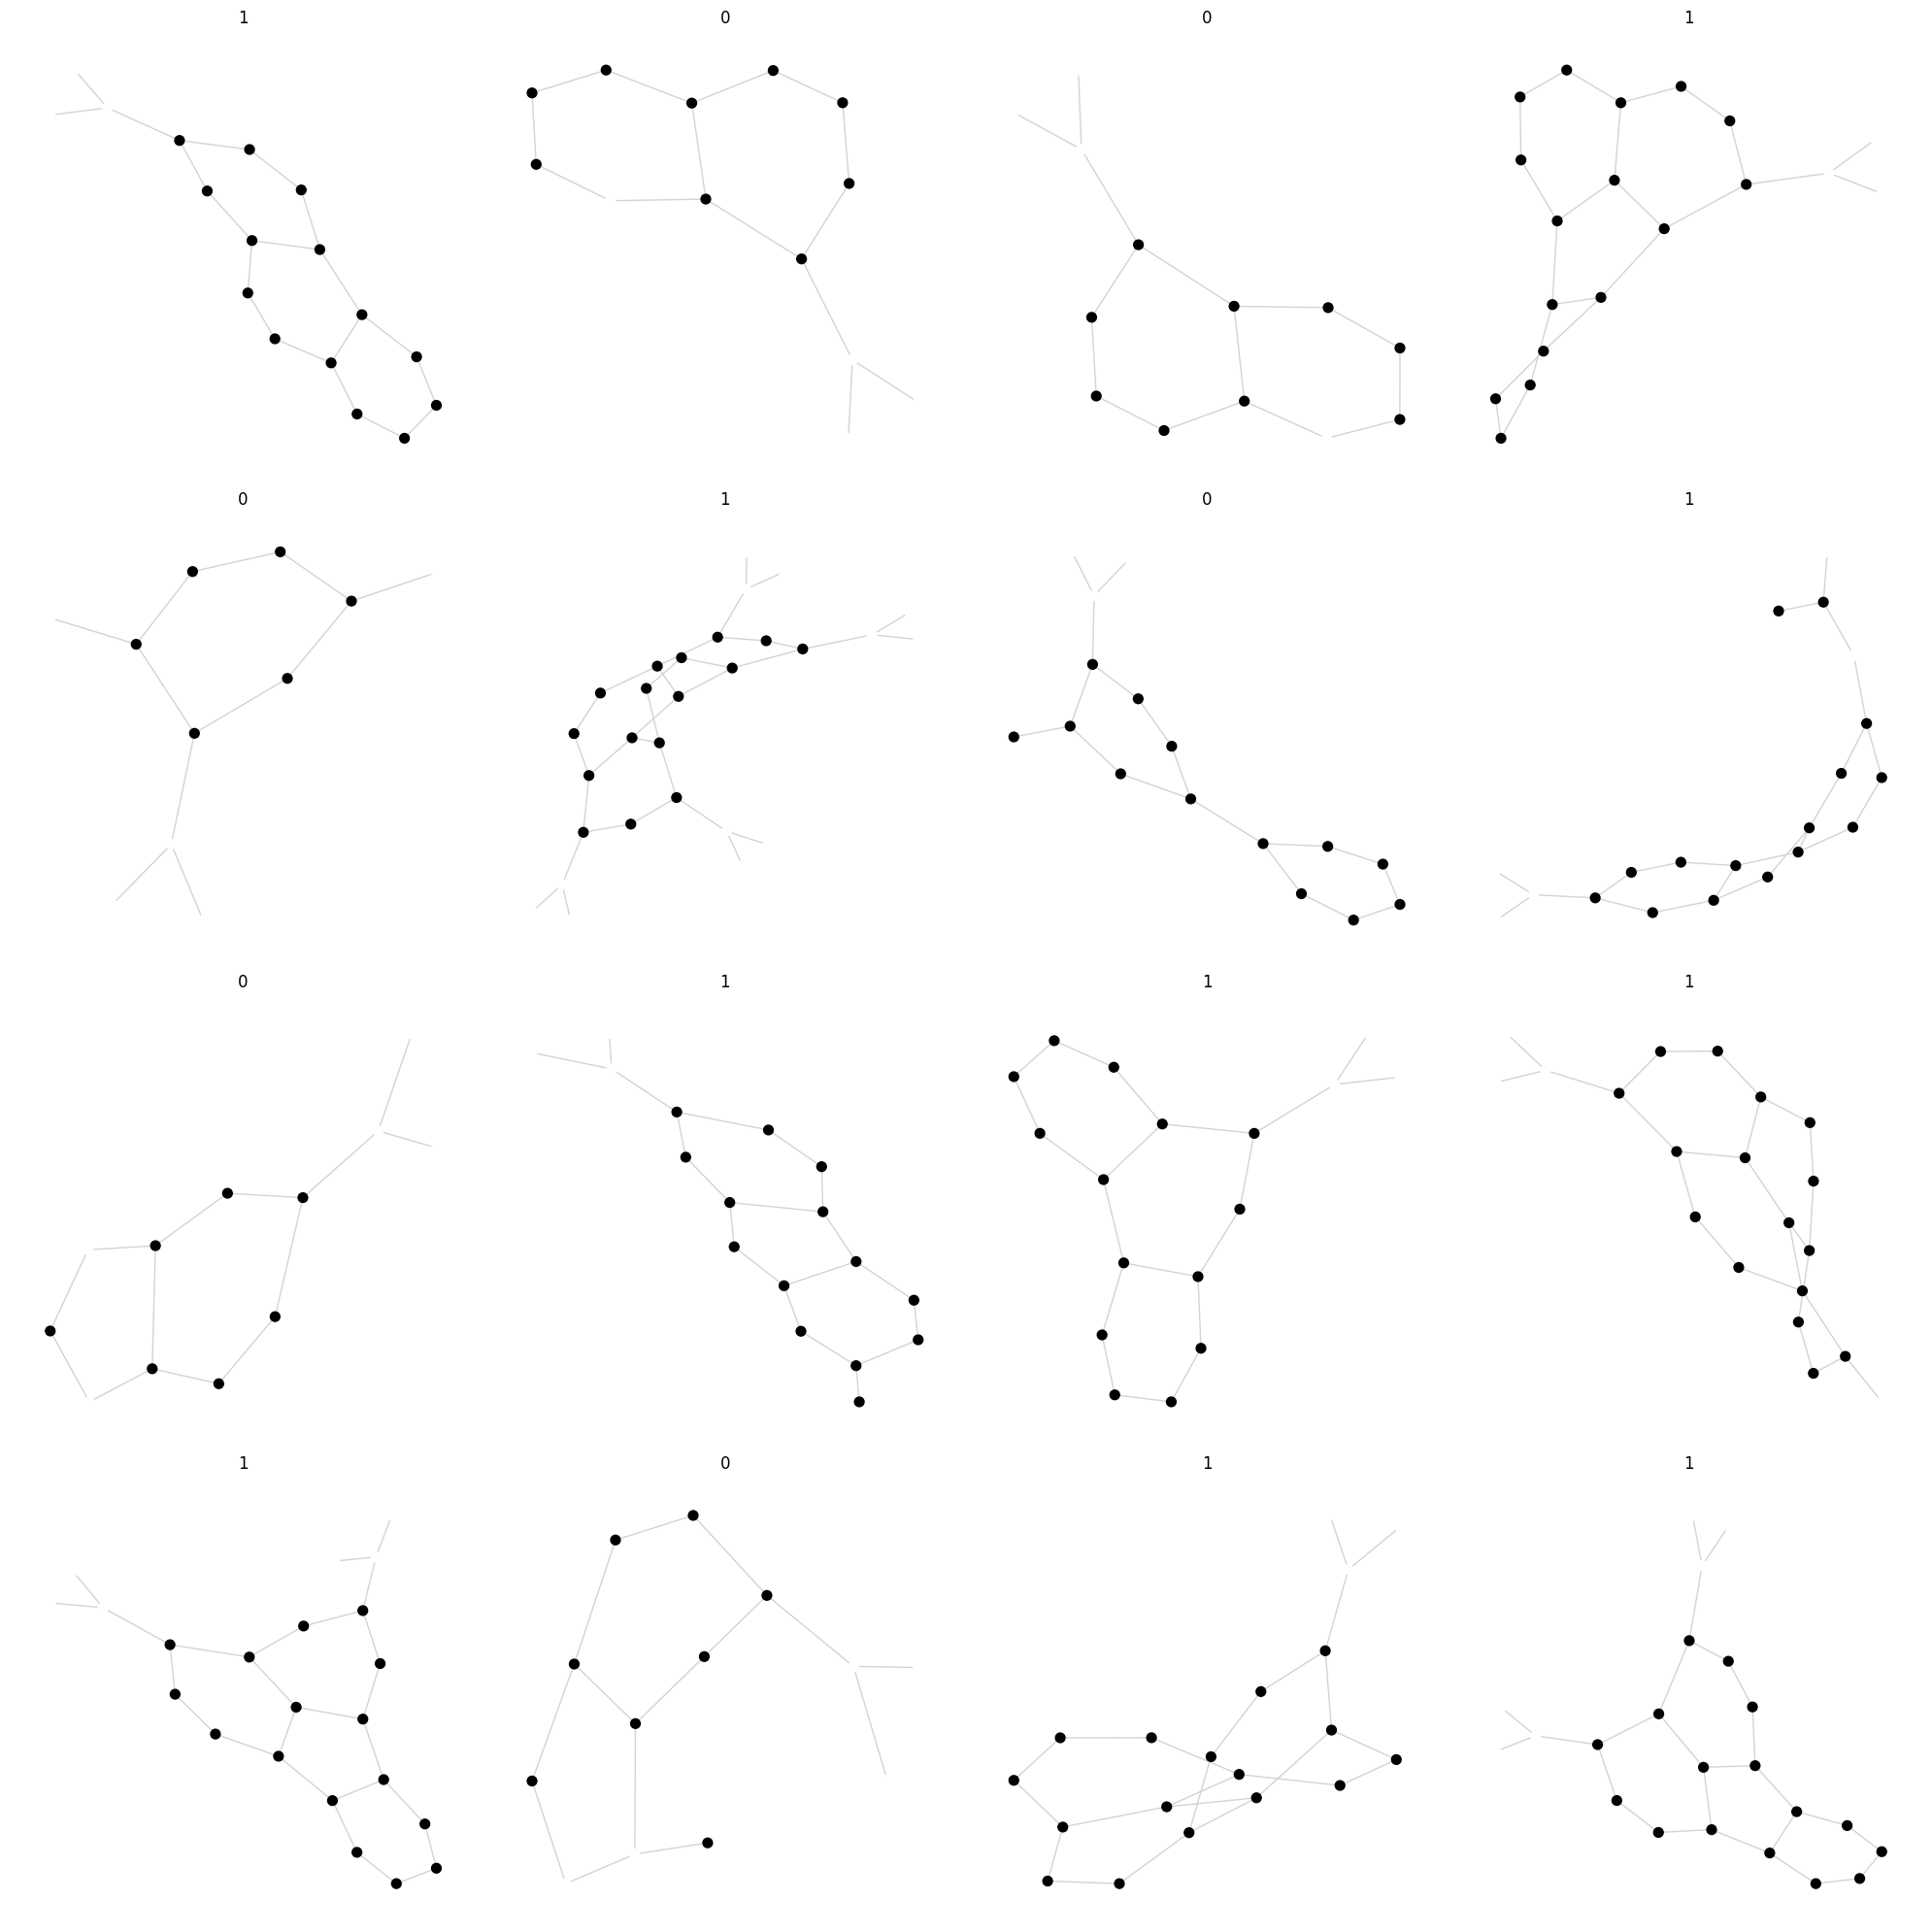

In [10]:
graphs = train[:16]

rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))

for i,ax in zip(range(16), axes.flat):
    data = graphs[i]
    G = to_networkx(data, to_undirected=True)
    pos = nx.spring_layout(G)
    ax.set_title(f"{data.y.item()}")
    nx.draw(G, pos, ax=ax, node_size=50, node_color=1-data.x[:,0], edge_color="lightgray", with_labels=False, cmap="gray")
plt.tight_layout()
plt.show()





# Batch processing in PyTorch Geometric

The DataLoader in PyTorch Geometric is designed to handle batches of graphs. To simplify things and to make the processing faster, a batch of graphs is represented as a single graph with additional attributes:
- `batch`: a tensor that maps each node to its respective graph in the batch
- `ptr`: a tensor that points to the start and end of each graph in the batch
- `y`: a tensor containing the graph labels
- `num_graphs`: the number of graphs in the batch
- `batch_size`: the batch size

In [11]:
example_loader = DataLoader(train, batch_size=4)
batch = next(iter(example_loader))

In [12]:
print(f"Batch: {batch.batch}")
print(f"Batch size: {batch.batch.size()}")
print(f"Number of graphs: {batch.num_graphs}")
print(f"ptr: {batch.ptr}")
print(f"y: {batch.y}")

Batch: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])
Batch size: torch.Size([62])
Number of graphs: 4
ptr: tensor([ 0, 17, 30, 43, 62])
y: tensor([1, 0, 0, 1])


It is easy to plot a batch using networkx, since it will treat it as a single graph.

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


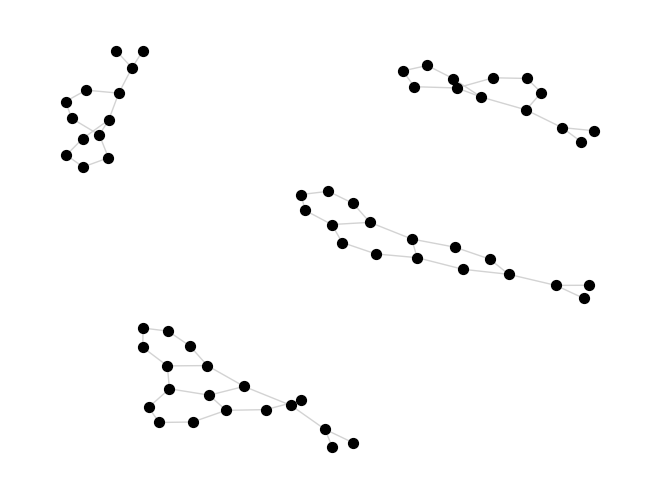

In [13]:
G = to_networkx(batch, to_undirected=True)
nx.draw(G, node_size=50, node_color="black", edge_color="lightgray", with_labels=False, cmap="gray")
plt.show()


# Network definition

# GNN Structure

Let us now define a network that uses Graph Convolutional Layers to classify the graphs. The network consists of the following layers:

## **Layers**
1. **Graph Convolutional Layers**:
   - **`conv1`**: A `GCNConv` layer that projects the input node features from `num_features` to a 64-dimensional latent space.
   - **`conv2`**: A second `GCNConv` layer that refines the features, maintaining the 64-dimensional latent space.
   - **`conv3`**: A third `GCNConv` layer for further feature refinement, keeping the output size as 64.

2. **Global Mean Pooling**:
   - Aggregates the node-level embeddings across all nodes in the graph to produce a graph-level representation of size `[batch_size, 64]`.

3. **Dropout Layer**:
   - Applies dropout with a probability of 0.5 to prevent overfitting.

4. **Classifier**:
   - A fully connected layer (`Linear`) that maps the graph-level representation from 64 dimensions to `num_classes`, corresponding to the classification task.


In [14]:



class Net(torch.nn.Module):
    def __init__(self, num_nodes, num_features, num_classes):
      super(Net, self).__init__()
      self.conv1 = GCNConv(num_features, 64)
      self.conv2 = GCNConv(64, 64)
      self.conv3 = GCNConv(64, 64)
      self.classifier = torch.nn.Linear(64, num_classes)

    def forward(self, data):
      x, edge_index = data.x, data.edge_index # h_0
      x = self.conv1(x, edge_index)           # h_1
      x = F.relu(x)
      x = self.conv2(x, edge_index)           # h_2
      x = F.relu(x)
      x = self.conv3(x, edge_index)           # h_3
      x = F.relu(x)

      x = global_mean_pool(x, data.batch)
      x = F.dropout(x, p=0.5, training=self.training)
      x = self.classifier(x)

      return x

In [15]:
def eval_accuracy(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        for data in test_loader:
            out = model(data)
            _, predicted = torch.max(out, 1)
            total += data.y.size(0)
            correct += (predicted == data.y).sum().item()
    return correct / total

# Model training

In [16]:
losses = []
accuracies = []
current_epoch = 0
num_epochs_per_run = 1000

model = Net(len(train[0].x), train.num_features, train.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

In [17]:

for e in track(range(num_epochs_per_run)):
    current_epoch += 1
    for step, data in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        out = model(data)

        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        with torch.no_grad():
            model.eval()
            accuracy = eval_accuracy(model, test_loader)
            accuracies.append(accuracy)

Output()

In [18]:
out = model(next(iter(test_loader)))

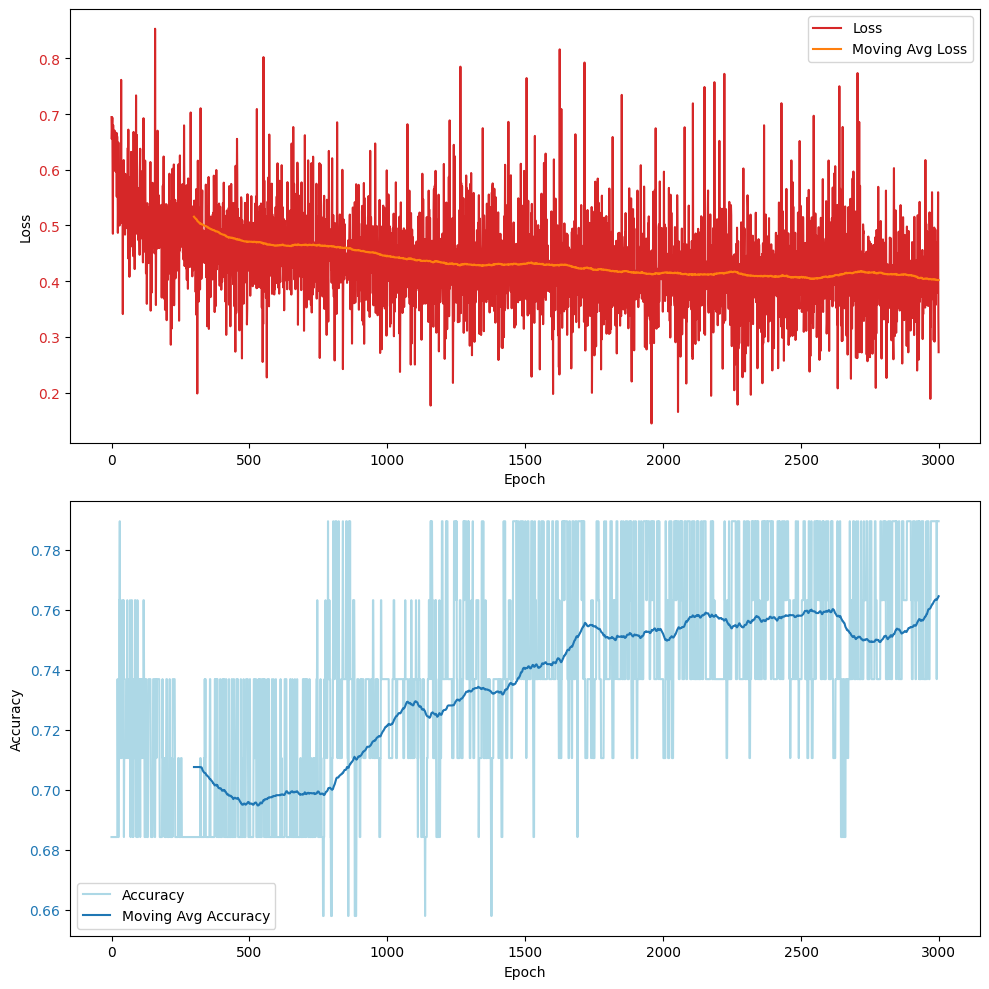

In [27]:
import pandas as pd

# Calculate moving averages
window_size = 300
losses_moving_avg = pd.Series(losses).rolling(window=window_size).mean()
accuracies_moving_avg = pd.Series(accuracies).rolling(window=window_size).mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot losses and moving average of losses
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.plot(range(len(losses)), losses, color='tab:red', label='Loss')
ax1.plot(range(len(losses_moving_avg)), losses_moving_avg, color='tab:orange', label='Moving Avg Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')
ax1.legend()

# Plot accuracies
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.plot(range(len(accuracies)), accuracies, color='lightblue', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend()


# Plot moving average of accuracies
ax2.plot(range(len(accuracies_moving_avg)), accuracies_moving_avg, color='tab:blue', label='Moving Avg Accuracy')
ax2.legend()

fig.tight_layout()
plt.show()
